In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import itertools
from collections import OrderedDict

In [0]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [0]:
x = normal_dist.sample()

In [4]:
x

tensor(0.9751)

In [0]:
x = normal_dist.sample([100])

In [6]:
x

tensor([-0.2297, -1.4699, -0.9743,  1.4647,  1.2115, -1.1523, -1.0646, -0.2574,
        -0.1789, -1.0827, -0.4084,  0.2708,  0.8100, -0.3153, -0.3835,  0.9930,
        -0.1224,  1.7591, -0.7908,  1.1788, -0.9725,  1.3558,  1.2006,  0.2354,
         1.3564, -0.5836, -0.7023, -2.4646, -0.1629,  1.3149, -1.2432,  0.2330,
         0.5294, -0.5055,  1.3809,  0.1236, -0.2933, -0.1012,  0.5671, -1.0663,
        -0.5349,  0.5125, -0.2929,  0.0641,  0.1939,  0.9018, -2.3981,  0.6396,
         0.8196,  1.1254,  1.3049,  1.6517,  0.6842, -0.9109, -0.5889, -1.3594,
         1.1598, -0.4645, -0.3729,  0.4805, -1.0582, -1.5714, -0.7112,  1.5706,
         0.6616, -1.0496,  0.0435,  0.9069, -1.0480, -0.0199, -0.8753,  2.0985,
        -2.7476,  0.0074,  0.6425, -0.8499,  0.8746,  1.2590,  0.1568,  0.7747,
        -0.0616, -0.0844, -0.5466, -0.2322,  1.0783, -1.2464,  0.9450,  0.1424,
         2.4970,  0.5442, -0.0945,  0.6857,  1.3560, -0.7441,  1.5916,  2.0834,
        -0.6256,  1.7943,  2.6379, -0.72

(array([ 3.,  0.,  6., 17., 22., 12., 17., 14.,  7.,  2.]),
 array([-2.7476368 , -2.2090864 , -1.6705363 , -1.1319859 , -0.59343565,
        -0.05488539,  0.4836649 ,  1.0222151 ,  1.5607655 ,  2.0993156 ,
         2.637866  ], dtype=float32),
 <a list of 10 Patch objects>)

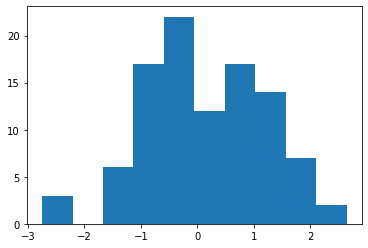

In [7]:
plt.hist(x.detach().numpy())

In [0]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    linear_op = -3 - 4*x + x**2
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

x_train, y_train = toy_poly()

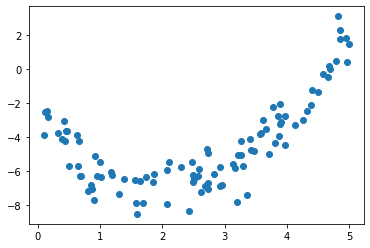

In [9]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

## module

In [10]:
var_mu = torch.tensor([0., 0.], requires_grad=True)
var_sigma = torch.tensor([1., 1.], requires_grad=True)
var_mu = nn.Parameter(var_mu)
var_sigma = nn.Parameter(var_sigma)

normal_dist = torchdist.Normal(loc=var_mu, scale=var_sigma)

normal_dist.rsample()

tensor([-0.7757,  1.3155], grad_fn=<AddBackward0>)

In [0]:
a = torch.tensor([1.0], requires_grad=True)

optimizer = torch.optim.SGD(params=[a], lr=1e-2)

optimizer.zero_grad()

a_dash = a + torch.tensor([2.0])
b = torch.tensor([1.0], requires_grad=False)
c = a_dash * b
loss = c.mean()
loss.backward()
optimizer.step()

optimizer.zero_grad()
c = a_dash * b
loss = c.mean()
loss.backward()
optimizer.step()


In [0]:
var_mu = torch.tensor([0., 0.], requires_grad=True)
var_sigma = torch.tensor([1., 1.], requires_grad=True)
var_mu = nn.Parameter(var_mu)
var_sigma = nn.Parameter(var_sigma)

normal_dist = torchdist.Normal(loc=var_mu, scale=var_sigma)

# a_dash = a + torch.tensor([2.0])
w_sample = normal_dist.rsample()
b = torch.tensor([1.0], requires_grad=False)
c1 = w_sample * b
c1.mean().backward()

w_sample = normal_dist.rsample()
c2 = w_sample * b
c2.mean().backward()

In [0]:
class CustomNormal(torch.distributions.Normal):
    def __init__(self, loc, scale, validate_args=None):        
        super(CustomNormal, self).__init__(loc, scale, validate_args)                

    def __getattribute__(self, name):        
        if name == 'scale':            
            return torch.exp(object.__getattribute__(self, name))
        else:            
            return object.__getattribute__(self, name)


In [14]:
var_mu = torch.tensor([0., 0.], requires_grad=True)
var_sigma = torch.tensor([1., 1.], requires_grad=True)
var_mu = nn.Parameter(var_mu)
var_sigma = nn.Parameter(var_sigma)
# var_sigma_pos = torch.distributions.transforms.ExpTransform()(var_sigma)
# var_sigma_pos = torch.exp(var_sigma)

# normal_dist = torchdist.Normal(loc=var_mu, scale=var_sigma_pos)
normal_dist = CustomNormal(loc=var_mu, scale=var_sigma)

optimizer = torch.optim.SGD(params=[var_mu, var_sigma], lr=1e-2)

class MyClass:
    def __init__(self):
        self.param = torch.Tensor([0., 0.])

obj = MyClass()
# param = torch.Tensor([0., 0.])

print(obj.param)

for i in range(2):
    optimizer.zero_grad()

    
    w_sample = normal_dist.rsample()
    print('w_sample', w_sample)
    # param.copy_(w_sample)
    # obj.param = w_sample
    
    setattr(obj, 'param', w_sample)

    x = torch.Tensor([2.])

    y = obj.param * x
    print(y)

    loss = y.mean()
    print(loss.detach().numpy())

    loss.backward()
    optimizer.step()

    print(var_mu.detach(), var_sigma.detach())

tensor([0., 0.])
w_sample tensor([-3.1503,  2.5689], grad_fn=<AddBackward0>)
tensor([-6.3006,  5.1378], grad_fn=<MulBackward0>)
-0.5814147
tensor([-0.0100, -0.0100]) tensor([1.0315, 0.9743])
w_sample tensor([2.3903, 1.5684], grad_fn=<AddBackward0>)
tensor([4.7806, 3.1368], grad_fn=<MulBackward0>)
3.958694
tensor([-0.0200, -0.0200]) tensor([1.0075, 0.9585])


In [0]:
class TensorModule:
    def __init__(self):
        self.training = True
        self._parameters = OrderedDict()
        self._modules = OrderedDict()
        self._buffers = OrderedDict()

    def __call__(self, *input, **kwargs):
        result = self.forward(*input, **kwargs)
        return result
    
    def forward(self, *input):
        raise NotImplementedError

    def __setattr__(self, name, value):
        def remove_from(*dicts):
            for d in dicts:
                if name in d:
                    del d[name]

        params = self.__dict__.get('_parameters')
        if name.startswith('p_') and isinstance(value, torch.Tensor):
            if params is None:
                raise AttributeError
            remove_from(self.__dict__, self._buffers, self._modules)
            self.register_parameter(name, value)
        elif params is not None and name in params:
            if value is not None:
                raise TypeError
            self.register_parameter(name, value)
        else:
            modules = self.__dict__.get('_modules')
            if isinstance(value, TensorModule):
                if modules is None:
                    raise AttributeError
                remove_from(self.__dict__, self._parameters, self._buffers)
                modules[name] = value
            elif modules is not None and name in modules:
                if value is not None:
                    raise TypeError
                modules[name] = value
            else:
                buffers = self.__dict__.get('_buffers')
                if buffers is not None and name in buffers:
                    if value is not None and not isinstance(value, torch.Tensor):
                        raise TypeError
                    buffers[name] = value
                else:
                    object.__setattr__(self, name, value)

    def __getattr__(self, name):
        if '_parameters' in self.__dict__:
            _parameters = self.__dict__['_parameters']
            if name in _parameters:
                return _parameters[name]

        if '_buffers' in self.__dict__:
            _buffers = self.__dict__['_buffers']
            if name in _buffers:
                return _buffers[name]
        
        if '_modules' in self.__dict__:
            _modules = self.__dict__['_modules']
            if name in _modules:
                return _modules[name]

    def register_parameter(self, name, param):
        # debug
        if name in self._parameters:
            prev_param = self._parameters[name]
        else:
            prev_param = None
        # print('%s: %s -> %s' % (name, str(prev_param), str(param)))

        if '.' in name:
            raise KeyError

        if param is None:
            self._parameters[name] = None
        elif not isinstance(param, torch.Tensor):
            raise TypeError
        else:
            self._parameters[name] = param

    def named_modules(self, memo=None, prefix=''):
        if memo is None:
            memo = set()
        if self not in memo:
            memo.add(self)
            yield prefix, self
            for name, module in self._modules.items():
                if module is None:
                    continue
                submodule_prefix = prefix + ('.' if prefix else '') + name
                for m in module.named_modules(memo, submodule_prefix):
                    yield m   

    def _named_members(self, get_members_fn, prefix='', recurse=True):
        memo = set()
        modules = self.named_modules(prefix=prefix) if recurse else [(prefix, self)]
        for module_prefix, module in modules:
            members = get_members_fn(module)
            for k, v in members:
                if v is None or v in memo:
                    continue
                memo.add(v)
                name = module_prefix + ('.' if module_prefix else '') + k
                yield name, v

    def named_parameters(self, prefix='', recurse=True):
        gen = self._named_members(
            lambda module: module._parameters.items(),
            prefix=prefix, recurse=True
        )
        for elem in gen:
            yield elem

    def _load_from_state_dict(self, state_dict, prefix):
        local_name_params = itertools.chain(self._parameters.items(), self._buffers.items())
        local_state = {k: v for k, v in local_name_params if v is not None}

        for name, param in local_state.items():
            key = prefix + name
            if key in state_dict:
                input_param = state_dict[key]
                setattr(self, name, input_param)
                # with torch.no_grad():                        
                # param.copy_(input_param)
            else:
                print('miss key: %s' % key)


    def set_params(self, state_dict):
        def load(module, prefix=''):
            module._load_from_state_dict(state_dict, prefix)
        
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        load(self)
        load = None
        
    def train(self, mode=True):
        self.training =  mode
        for module in self.children():
            module.train(mode)
        return self

    def eval(self):
        return self.train(False)

    def children(self):
        for name, module in self.named_children():
            yield module

    def named_children(self):
        memo = set()
        for name, module in self._modules.items():
            if module is not None and module not in memo:
                memo.add(module)
                yield name, module

class TensorLinear(TensorModule):
    def __init__(self, in_features, out_features, bias=True):
        super(TensorLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        # self.weight = TensorParameter((out_features, in_features))
        self.p_weight = torch.zeros((out_features, in_features), dtype=torch.float32)
        if bias:
            self.p_bias = torch.zeros((out_features, ), dtype=torch.float32)
        else:
            # original self.register_parameter('bias', None)
            self.p_bias = None

    def forward(self, input):
        return F.linear(input, self.p_weight, self.p_bias)

class TensorLinearNet(TensorModule):
    def __init__(self):
        super(TensorLinearNet, self).__init__()
        self.linear1 = TensorLinear(1, 16)
        self.linear2 = TensorLinear(16, 1)
        self.linear3 = TensorLinear(16, 1)
        self.relu = nn.ReLU()        

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        # x = self.relu(x)
        # x = self.linear3(x)

        return x

## model

In [0]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
    def forward(self, w, x):
        """
        w: shape of (3,)
        x: shape of (batch,)
        """
        #         phi_x = torch.tensor([])
        y = w[0] + w[1]*x + w[2]*x**2
        return y

class LinearNet2(nn.Module):
    def __init__(self):
        super(LinearNet2, self).__init__()

        self.linear1 = nn.Linear(1, 8)
        self.linear2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)

        return x

In [0]:
class VImodel_org(nn.Module):
    """
    q(w; eta)
    """
    def __init__(self, model):
        super(VImodel, self).__init__()

        self.model = model
        self.eta_mu = nn.Parameter(torch.tensor([0., 0., 0.]))
        self.eta_log_sigma = nn.Parameter(torch.tensor([0., 0., 0.]))
    
    def dist(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        return q_w
    '''
    def rsample(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        # shape of w: (3,)
        w = q_w.rsample()
        
        return w
    '''

class ParameterDistribution:
    def __init__(self, dist):
        """
        Parameters
        ----------
        dist: dict
            key: paramter name
            value: torch.distributions.distribution.Distribution
        """
        if not isinstance(dist, OrderedDict):
            raise ValueError('dist must be OrderedDict')
        self.dist = dist

    def sample(self):
        w_sample = OrderedDict()
        for n, d in self.dist.items():
            w_sample[n] = d.sample()

        return w_sample

    def rsample(self):
        w_sample = OrderedDict()
        for n, d in self.dist.items():
            w_sample[n] = d.rsample()

        return w_sample

    def log_prob(self, w):
        """
        Parameters
        ----------
        w: dict
            key: parameter name
            value: torch.Tensor
        """
        sum_log_prob = 0
        for k, v in w.items():
            distribution = self.dist[k]
            sum_log_prob += distribution.log_prob(v).sum()

        return sum_log_prob

class VIModel(nn.Module):
    def __init__(self, model):
        super(VIModel, self).__init__()
        # set param

        param_dict = self.get_params(model)
        self.dist = self.normal_dist(param_dict)        
        self.__setparams(param_dict)        

    def get_params(self, model):
        param_dict = OrderedDict()
        for n, p in model.named_parameters():
            mu = nn.Parameter(torch.zeros_like(p.data))
            log_sigma = nn.Parameter(torch.zeros_like(p.data))
            
            eta_dict = {
                'mu': mu,
                'log_sigma': log_sigma
            }
            param_dict[n] = eta_dict

        return param_dict

    def normal_dist(self, param_dict):
        dist = OrderedDict()
        for n, eta_dict in param_dict.items():
            mu = eta_dict['mu']
            log_sigma = eta_dict['log_sigma']
            # sigma = torch.exp(log_sigma)

            # dist[n] = torchdist.Normal(mu, sigma)
            dist[n] = CustomNormal(mu, log_sigma)

        return dist

    def __setparams(self, param_dict):
        for n, eta_dict in param_dict.items():
            for eta_name, eta_param in eta_dict.items():
                # parameter
                name =  '_'.join([n.replace('.', '_'), eta_name])
                setattr(self, name, eta_param)
                

def normal_dist(model):
    dist = OrderedDict()
    for n, p in model.named_parameters():
        mu = nn.Parameter(torch.zeros_like(p.data))
        sigma = torch.exp(nn.Parameter(torch.zeros_like(p.data)))        
        dist[n] = torchdist.Normal(mu, sigma)

    return dist

def normal_prior_dist(model):
    dist = OrderedDict()
    for n, p in model.named_parameters():
        param_size = p.size()        
        mu = torch.zeros(param_size)
        # [10, 10, ...]
        sigma = torch.zeros((1,)).new_full(param_size, 10.0)
        dist[n] = torchdist.Normal(mu, sigma)

    return dist

In [0]:
def kl_divergence(q_w, p_w, model, x, y):

    # sampling from q(w)
    w_sample = q_w.rsample()
    
    # l1_p_w = w_sample['linear1.p_weight']
    # print(l1_p_w, id(l1_p_w))
    # print(model.linear1.p_weight, id(model.linear1.p_weight))

    # print('w_sample', w_sample)
    # model.load_state_dict(w_sample)
    # freeze_param(model)
    # printw(model)
    # setw(model, w_sample, '') 
    model.set_params(w_sample)

    # l1_p_w = model.linear1._parameters['p_weight']
    # print(l1_p_w, id(l1_p_w))
    # print(model.linear1.p_weight, id(model.linear1.p_weight))
    
    # calculate f(x)
    # p(y|x,w) = N(f(x; w), 1)
    output = model(x)

    # print('output', output)
    p_y_xw = torchdist.Normal(output, torch.ones_like(output))

    # log(p(w, x, y)) = log(p(w)) + sum(log(p(y|x,w)))    
    val_log_joint_prob = p_w.log_prob(w_sample) + p_y_xw.log_prob(y).sum()

    val_log_q_w = q_w.log_prob(w_sample)
    
    return val_log_q_w - val_log_joint_prob


def loss_func(model, x, y):
    y_pred = model(x)
    loss = ((y - y_pred)**2).mean()
    return loss

def freeze_param(model):
    for p in model.parameters():
        p.requires_grad = False

def setw(module, w_dict, prefix):
    var_names = list(module._parameters.keys())
    for var_name in var_names:
        if prefix == '':
            full_name = var_name
        else:
            full_name = '.'.join([prefix, var_name])
        print(full_name)
        value = w_dict[full_name]        
        # module.__setattr__ == 
        
        # value_param =  nn.Parameter(value, requires_grad=False)
        # dengerous process
        value.__class__ = nn.Parameter
        setattr(module, var_name, value)
        print('test')
        # module.register_parameter(var_name, value_param)
        # module._parameters[var_name] = value
        
    for child_name, child_module in module._modules.items():
        if prefix == '':
            child_full_name = child_name
        else:
            child_full_name = '.'.join([prefix, child_name])
        setw(child_module, w_dict, child_full_name)

def printw(module, prefix=''):
    var_names = list(module._parameters.keys())
    for var_name in var_names:        
        if prefix == '':
            full_name = var_name
        else:
            full_name = '.'.join([prefix, var_name])
        print(full_name)
        print(getattr(module, var_name))        

    for child_name, child_module in module._modules.items():
        if prefix == '':
            child_full_name = child_name
        else:
            child_full_name = '.'.join([prefix, child_name])
        printw(child_module, child_full_name)

def write_graph(writer, model, x):
    writer.add_graph(model, input_to_model=x)

## exec

In [0]:
# model = LinearNet2()
model = TensorLinearNet()
vimodel = VIModel(model)
q_w = ParameterDistribution(vimodel.dist)
p_w = ParameterDistribution(normal_prior_dist(model))

optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-4)

In [20]:
model.train()
for i in range(10000):    
    with torch.set_grad_enabled(True):    
        optimizer.zero_grad()
        # loss = kl_divergence2(q_w, p_w, vimodel, x_train, y_train)
        loss = kl_divergence(q_w, p_w, model, x_train, y_train)        
        # loss = loss_func(model, x_train, y_train)
        loss.backward()
        optimizer.step()
        
    
    if (i+1) % 100 == 0:
        # mu = vimodel.eta_mu.detach().numpy()
        # sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
        # print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))
        # print(loss.size())
        print('iter: %d loss: %f ' % (i, loss.item(),))

iter: 99 loss: 772.380493 
iter: 199 loss: 653.631958 
iter: 299 loss: 585.818054 
iter: 399 loss: 639.038391 
iter: 499 loss: 645.086365 
iter: 599 loss: 614.361755 
iter: 699 loss: 593.973877 
iter: 799 loss: 594.942566 
iter: 899 loss: 520.285034 
iter: 999 loss: 572.937073 
iter: 1099 loss: 573.818665 
iter: 1199 loss: 581.060364 
iter: 1299 loss: 507.344910 
iter: 1399 loss: 573.329529 
iter: 1499 loss: 567.001282 
iter: 1599 loss: 582.096558 
iter: 1699 loss: 578.445312 
iter: 1799 loss: 573.031799 
iter: 1899 loss: 586.380920 
iter: 1999 loss: 562.461975 
iter: 2099 loss: 593.880676 
iter: 2199 loss: 528.276672 
iter: 2299 loss: 567.287903 
iter: 2399 loss: 563.055603 
iter: 2499 loss: 558.969849 
iter: 2599 loss: 581.409485 
iter: 2699 loss: 577.058716 
iter: 2799 loss: 577.416382 
iter: 2899 loss: 572.287781 
iter: 2999 loss: 573.747559 
iter: 3099 loss: 570.390503 
iter: 3199 loss: 550.226685 
iter: 3299 loss: 572.549194 
iter: 3399 loss: 573.384399 
iter: 3499 loss: 560.7648

## prediction

Calculate prediction distribution
$$
\begin{align}
p(y_*| x_*, X, Y) &= \int p(y_*| x_*, W) p(W| X, Y) dW \\
&\approx \int p(y_*| x_*, W) q(W; \eta) dW 
\end{align}
$$

In [0]:
def predict(q_w, model, x, n_samples):    
    
    approx_y = 0    
    with torch.no_grad():
        for i in range(n_samples):
            # sampling from q(w)
            w_sample = q_w.sample()
            model.set_params(w_sample)
            # calculate f(x)
            output = model(x)

            # p(y|x,w) = N(f(x; w), 1)
            p_y_xw = torchdist.Normal(output, torch.ones_like(output))

            # sampling from p(y, w)
            y_sample = p_y_xw.sample()

            approx_y += y_sample / n_samples
    
    return approx_y

In [0]:
def predict_data(q_w, model):
    n_samples = 100
    x_pred = 5 * torch.rand(100, 1)
    y_pred = predict(q_w, model, x_pred, n_samples)
    
    return x_pred, y_pred

x_pred, y_pred = predict_data(q_w, model)

2


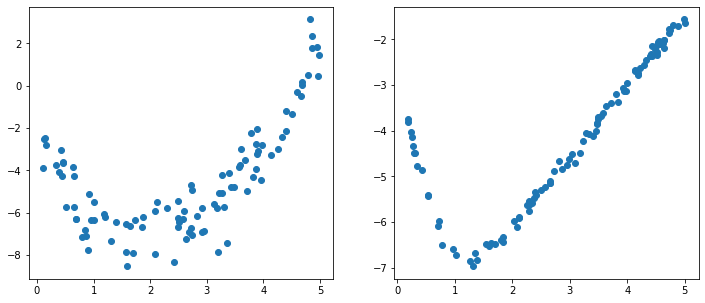

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
print(len(axes))
axes[0].plot(x_train.numpy(), y_train.numpy(), 'o')
axes[1].plot(x_pred.numpy(), y_pred.numpy(), 'o')

In [0]:
def log_joint_prob(w0, w1, w2, x, y):
    prior_w0 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w1 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w2 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    
    linear = w0 + w1*x + w2*x**2
    likelihood = torchdist.Normal(linear, torch.ones_like(linear))
    
    return (
        prior_w0.log_prob(w0) +
        prior_w1.log_prob(w1) +
        prior_w2.log_prob(w2) +
        likelihood.log_prob(y).mean()
    )

In [0]:
'''
w0 = torch.nn.Parameter(torch.tensor(1.))
w1 = torch.nn.Parameter(torch.tensor(1.))
w2 = torch.nn.Parameter(torch.tensor(1.))

optimizer = torch.optim.Adam(params=[w0, w1, w2], lr=1e-3)

for i in range(30000):
    optimizer.zero_grad()
    log_joint_prob_value = log_joint_prob(w0, w1, w2, x_train, y_train)
    loss_value = - log_joint_prob_value
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 1000 == 0 or (i==0):
        print(loss_value.detach().numpy())
'''